# Quantitative Trading System

This notebook integrates the following components:
1. Order Book Simulation
2. Mean Reversion Strategy
3. Backtesting Framework

## Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from collections import deque
import sys
import os
%run mean_reversion.py
# Add the current directory to path to ensure imports work
sys.path.append(os.path.abspath('.'))

# Import our custom modules
from order_book import OrderBook
from mean_reversion import MeanReversionStrategy

## 1. Order Book Demonstration

In [2]:
# Create an instance of the order book
book = OrderBook()

# Add some sample orders
print("Adding orders to the book...")
book.add_order(price=100.0, quantity=10, side='buy')
book.add_order(price=101.0, quantity=5, side='buy')
book.add_order(price=99.0, quantity=7, side='buy')
book.add_order(price=102.0, quantity=3, side='sell')
book.add_order(price=103.0, quantity=8, side='sell')
book.add_order(price=101.5, quantity=4, side='sell')

# Print the current order book state
book.output()

# Match orders
print("\nMatching orders...")
book.match_orders()

# Print the order book after matching
print("\nOrder book after matching:")
book.output()

Adding orders to the book...

Current order book:
Bids (Buy orders):
1. Price: 101.0, Quantity: 5
2. Price: 100.0, Quantity: 10
3. Price: 99.0, Quantity: 7

Asks (Sell orders):
1. Price: 101.5, Quantity: 4
2. Price: 102.0, Quantity: 3
3. Price: 103.0, Quantity: 8

Matching orders...

Order book after matching:

Current order book:
Bids (Buy orders):
1. Price: 101.0, Quantity: 5
2. Price: 100.0, Quantity: 10
3. Price: 99.0, Quantity: 7

Asks (Sell orders):
1. Price: 101.5, Quantity: 4
2. Price: 102.0, Quantity: 3
3. Price: 103.0, Quantity: 8


## 2. Mean Reversion Strategy

In [3]:
# Load historical stock data
print("Loading historical stock data...")
stock_data = yf.download('AAPL', start='2020-01-01', end='2022-01-01')
print(f"Loaded {len(stock_data)} days of data")
stock_data.head()

Loading historical stock data...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Loaded 505 days of data


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716072,72.776598,71.466812,71.721019,135480400
2020-01-03,72.009102,72.771729,71.783947,71.941313,146322800
2020-01-06,72.582916,72.621654,70.876083,71.127873,118387200
2020-01-07,72.241531,72.849208,72.021215,72.592578,108872000
2020-01-08,73.403633,73.706264,71.943744,71.943744,132079200


In [4]:
data = stock_data['Close']
data

Ticker,AAPL
Date,
2020-01-02,72.716072
2020-01-03,72.009102
2020-01-06,72.582916
2020-01-07,72.241531
2020-01-08,73.403633
...,...
2021-12-27,177.228806
2021-12-28,176.206680
2021-12-29,176.295151



Stock data with signals:


Price,Close,High,Low,Open,Volume,Signal
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,
2020-01-02,72.716072,72.776598,71.466812,71.721019,135480400,HOLD
2020-01-03,72.009102,72.771729,71.783947,71.941313,146322800,HOLD
2020-01-06,72.582916,72.621654,70.876083,71.127873,118387200,HOLD
2020-01-07,72.241531,72.849208,72.021215,72.592578,108872000,HOLD
2020-01-08,73.403633,73.706264,71.943744,71.943744,132079200,HOLD


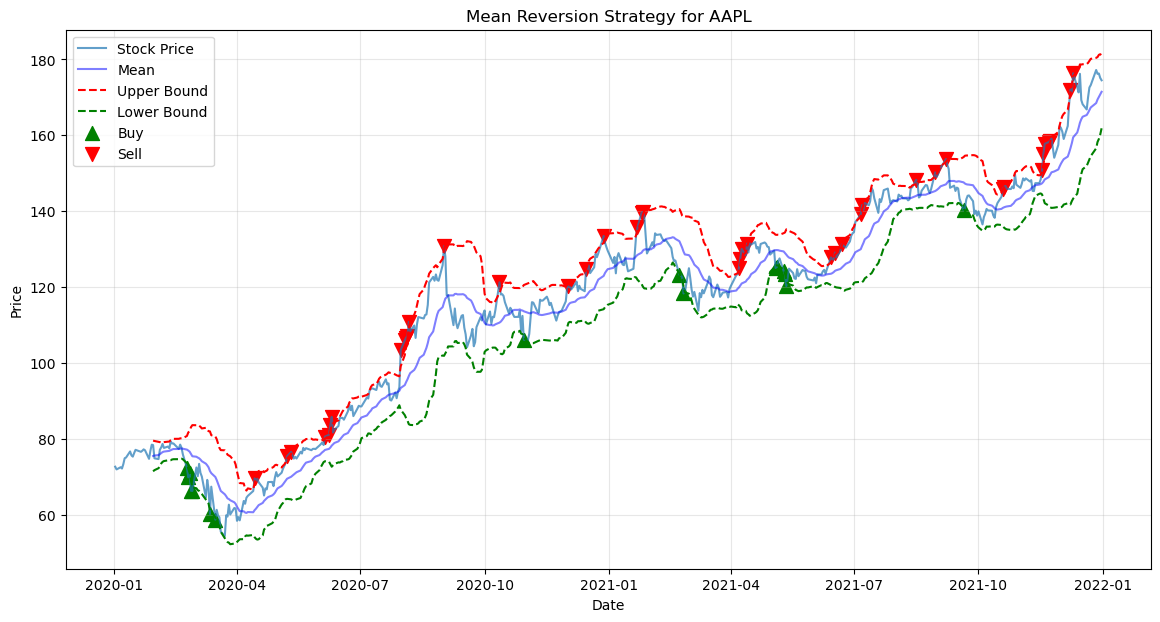

In [5]:

# Create and apply the mean reversion strategy
strategy = MeanReversionStrategy(stock_data['Close'])
signals = strategy.generate_signals()
stock_data['Signal'] = signals

# Display the first few rows of the data with signals
print("\nStock data with signals:")
display(stock_data.head())

# Plot the strategy
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Stock Price', alpha=0.7)
plt.plot(strategy.mean, linestyle='-', color='blue', label='Mean', alpha=0.5)
plt.plot(strategy.upper_band, linestyle='dashed', color='red', label='Upper Bound')
plt.plot(strategy.lower_band, linestyle='dashed', color='green', label='Lower Bound')

# Mark buy and sell signals
buy_signals = stock_data[stock_data['Signal'] == 'BUY']
sell_signals = stock_data[stock_data['Signal'] == 'SELL']

plt.scatter(buy_signals.index, buy_signals['Close'], color='green', marker='^', s=100, label='Buy')
plt.scatter(sell_signals.index, sell_signals['Close'], color='red', marker='v', s=100, label='Sell')

plt.title('Mean Reversion Strategy for AAPL')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Backtesting

In [20]:
def backtest_strategy(stock_data, initial_capital=10000):
    capital = initial_capital
    position = 0  # Now strictly scalar
    portfolio_value = []
    trades = []
    
    # Convert Close prices to scalar series
    close_prices = stock_data['Close'].squeeze()  # Converts DF->Series if single column
    
    for i in range(len(stock_data)):
        current_price = close_prices.iloc[i]  # Guaranteed scalar
        
        # Calculate current portfolio value
        current_value = capital + (position * current_price)
        portfolio_value.append(current_value)
        
        # Get trading signal
        signal = stock_data['Signal'].iloc[i]
        
        # Execute trades
        if signal == 'BUY' and position == 0:
            max_shares = capital // current_price
            if max_shares > 0:
                position = max_shares  # Scalar assignment
                capital -= position * current_price
                trades.append(('BUY', current_price, position, stock_data.index[i]))
                
        elif signal == 'SELL' and position > 0:
            capital += position * current_price
            trades.append(('SELL', current_price, position, stock_data.index[i]))
            position = 0  # Scalar reset
    
    # Final portfolio value
    final_value = capital + (position * close_prices.iloc[-1])
    return final_value, trades, portfolio_value

Initial Capital: $10,000.00
Final Portfolio Value: $11759.80
Return: 17.60%
Number of trades: 10

Trade History:
BUY - 72.36204528808594: .2f shares at $138.00
SELL - 69.66100311279297: .2f shares at $138.00
BUY - 106.14924621582031: .2f shares at $90.00
SELL - 120.22222900390625: .2f shares at $90.00
BUY - 123.25831604003906: .2f shares at $88.00
SELL - 125.11698913574219: .2f shares at $88.00
BUY - 125.06806182861328: .2f shares at $88.00
SELL - 127.85763549804688: .2f shares at $88.00
BUY - 140.27706909179688: .2f shares at $80.00
SELL - 145.98866271972656: .2f shares at $80.00


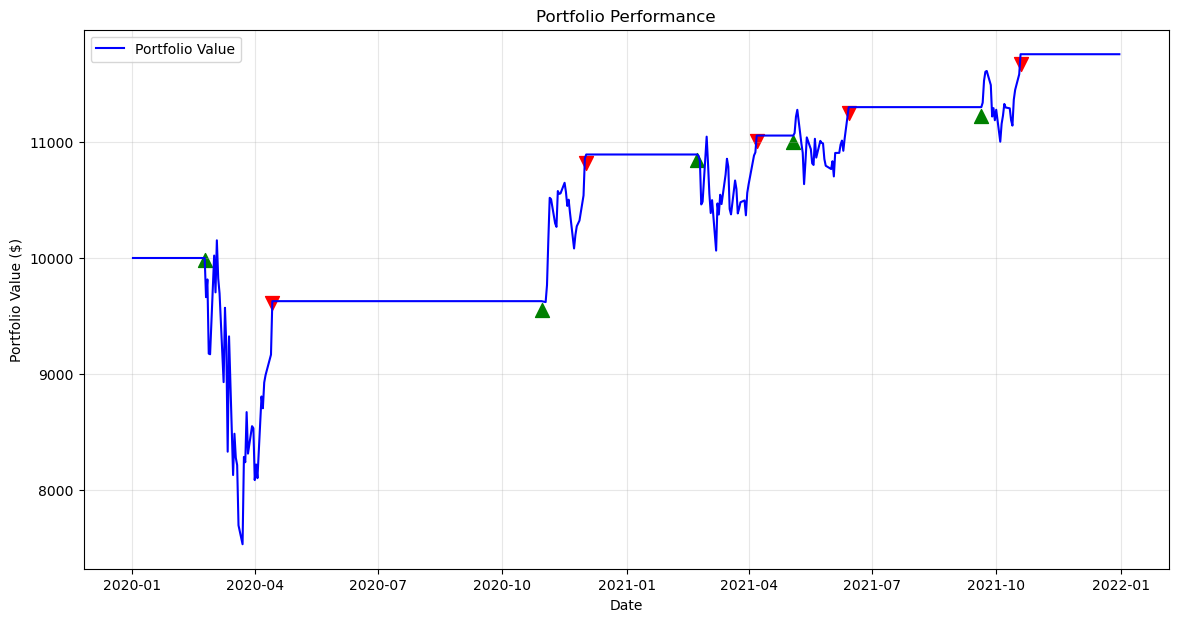

In [25]:


# Run the backtest
final_value, trades, portfolio_values = backtest_strategy(stock_data)

# Print results
print(f"Initial Capital: $10,000.00")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Return: {((final_value / 10000) - 1) * 100:.2f}%")
print(f"Number of trades: {len(trades)}")

# Display trade history
print("\nTrade History:")
for date, action, price, shares in trades[:10]:  # Show first 10 trades
    print(f"{date} - {action}: {shares:.2f} shares at ${price:.2f}")
if len(trades) > 10:
    print(f"... and {len(trades) - 10} more trades")

# Plot portfolio performance
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, portfolio_values, label='Portfolio Value', color='blue')

# Add buy/sell markers
for action, price, shares, date in trades:
    if action == 'BUY':
        plt.scatter(date, price * shares, color='green', marker='^', s=100)
    else:  # SELL
        plt.scatter(date, price * shares, color='red', marker='v', s=100)

plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 4. Strategy Performance Analysis

Performance Metrics:
Total Return: 17.60%
Annual Return: 8.44%
Daily Volatility: 1.65%
Sharpe Ratio: 0.44
Maximum Drawdown: 22.32%
Buy & Hold Return: Ticker
AAPL    1.399969
dtype: float64%


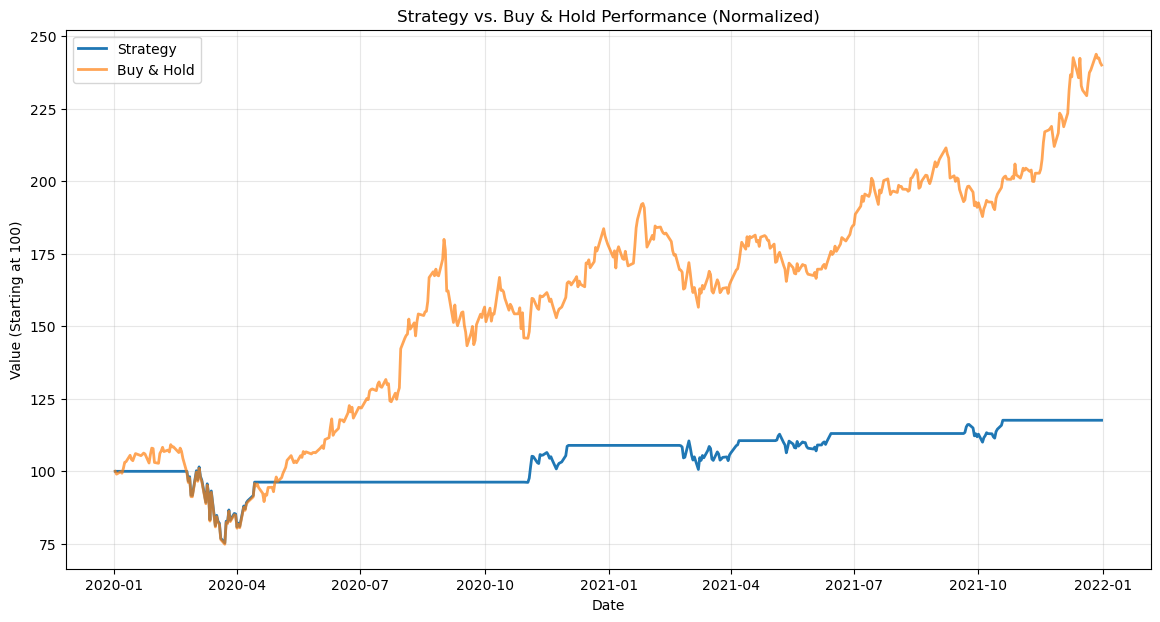

In [27]:
# Calculate performance metrics
def calculate_metrics(portfolio_values, stock_data):
    # Convert to numpy arrays for calculations
    portfolio_returns = np.array([(portfolio_values[i] - portfolio_values[i-1]) / portfolio_values[i-1] 
                               for i in range(1, len(portfolio_values))])
    
    # Calculate metrics
    total_return = (portfolio_values[-1] / portfolio_values[0]) - 1
    annual_return = (1 + total_return) ** (252 / len(portfolio_returns)) - 1
    daily_std = np.std(portfolio_returns)
    sharpe_ratio = np.mean(portfolio_returns) / daily_std * np.sqrt(252)  # Annualized Sharpe
    max_drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values) / np.max(portfolio_values)
    
    # Buy & Hold comparison
    buy_hold_return = (stock_data['Close'].iloc[-1] / stock_data['Close'].iloc[0]) - 1
    
    return {
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Daily Volatility': daily_std,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Buy & Hold Return': buy_hold_return
    }

# Calculate and display the metrics
metrics = calculate_metrics(portfolio_values, stock_data)

print("Performance Metrics:")
print(f"Total Return: {metrics['Total Return'] * 100:.2f}%")
print(f"Annual Return: {metrics['Annual Return'] * 100:.2f}%")
print(f"Daily Volatility: {metrics['Daily Volatility'] * 100:.2f}%")
print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
print(f"Maximum Drawdown: {metrics['Max Drawdown'] * 100:.2f}%")
print(f"Buy & Hold Return: {metrics['Buy & Hold Return']}%")

# Compare strategy vs. Buy & Hold
plt.figure(figsize=(14, 7))

# Normalize values to start at 100
norm_portfolio = [v * 100 / portfolio_values[0] for v in portfolio_values]
norm_stock = stock_data['Close'] * 100 / stock_data['Close'].iloc[0]

plt.plot(stock_data.index, norm_portfolio, label='Strategy', linewidth=2)
plt.plot(stock_data.index, norm_stock, label='Buy & Hold', linewidth=2, alpha=0.7)

plt.title('Strategy vs. Buy & Hold Performance (Normalized)')
plt.xlabel('Date')
plt.ylabel('Value (Starting at 100)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()